In [192]:
from scipy.spatial import distance
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
from numpy.linalg import matrix_rank
import numpy as np
import gudhi as gd
import matplotlib
import scipy.spatial as spatial
import bisect
import matplotlib
from scipy.cluster import hierarchy
from urllib.request import urlopen
from io import BytesIO
from gudhi import AlphaComplex
from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import ward, fcluster
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram
import time
from scipy.spatial import KDTree
from sklearn.datasets import make_blobs
from sklearn.metrics import calinski_harabasz_score
import pandas as pd
import random
from sklearn.cluster import DBSCAN
import hdbscan
from gudhi.clustering.tomato import Tomato
import genieclust
from scipy.spatial.distance import pdist
from sklearn import metrics

# Data input & preparation

In [193]:
# initialise data points
data = [[0, 0], [5, 0], [3, 4], [10,4]]
x = [0, 5, 3, 10]
y = [0, 0, 4, 4]

dist_matrix = distance.cdist(data, data, 'euclidean') # calculate distance matrix (can change distance metric)
unique_dist = sorted(list(set(i for j in dist_matrix for i in j))) # unique distance values
K = len(data)
data_enc = dict()
for i in range(K):
    data_enc[str(data[i])] = i
incr = 0.000000000000001

# Functions sections

## Filtration calculation

In [194]:
def get_filtration(dist):
    filtration = []
    for i in range(0, K):
        for j in range(0, K):
            if i > j:
                continue
            elif i == j:
                filtration.append(([i], dist[i][j]))
            else:
                filtration.append(([i, j], dist[i][j]))
    filtration = sorted(filtration, key=lambda x: (x[1], x[0]))
    return transform_filtration(filtration)  

def transform_filtration(filtration):
    new_filtration = []
    new_filtration.append(filtration[0])
    if filtration[1][1] == filtration[0][1]:
        new_filtration.append((filtration[1][0], filtration[1][1] + incr))
    else:
        new_filtration.append(filtration[1])    
    for i in range(2, len(filtration)):
        if filtration[i][1] == filtration[i - 1][1] and filtration[i][1] == filtration[i - 2][1]:
            new_filtration.append((filtration[i][0], new_filtration[-1][1] + incr))
        elif filtration[i][1] == filtration[i - 1][1]:
            new_filtration.append((filtration[i][0], filtration[i - 1][1] + incr))
        else:
            new_filtration.append(filtration[i])
    return new_filtration
    
# get filtration if scipy distance is passed
def get_filtration_from_scipy_dist(data, dist_type):
    dist = cdist(data, data, dist_type)
    return get_filtration(dist)

# get filtration based on kernrel density
def get_filtration_from_density(data, kernel_type, bandwidth):
    kde = KernelDensity(kernel=kernel_type, bandwidth=bandwidth).fit(data)
    point_density = np.exp(kde.score_samples(data)).tolist()
    maximum = np.max(np.exp(kde.score_samples(data)))
    second_maximum = np.sort(np.exp(kde.score_samples(data)))[-2]
    dist = [[0 for i in range(K)] for j in range(K)]
    for i in range(K):
        for j in range(K):
            if i < j:
                dist[i][j] = second_maximum + maximum - (point_density[i] + point_density[j])
                dist[j][i] = second_maximum + maximum - (point_density[i] + point_density[j])
    return get_filtration(dist)

def get_not_normalized_filtration_from_density(data, r):
    tree = KDTree(data)
    densities = tree.query_ball_point(data, r)
    point_density = np.array([len(neighbors) for neighbors in densities])
    maximum = max(point_density)
    second_maximum = sorted(point_density)[-2]
    dist = [[0 for i in range(K)] for j in range(K)]
    for i in range(K):
        for j in range(K):
            if i < j:
                dist[i][j] = second_maximum + maximum - (point_density[i] + point_density[j])
                dist[j][i] = second_maximum + maximum - (point_density[i] + point_density[j])
    return get_filtration(dist)

def get_filtration_from_curvature(data):
    x = np.array(data)[:, 0]
    y = np.array(data)[:, 1]
    dx = np.gradient(x)
    dy = np.gradient(y)
    d2x = np.gradient(dx)
    d2y = np.gradient(dy)
    curvatures = np.abs(d2x * dy - dx * d2y) / (dx**2 + dy**2)**1.5
    dist = [[0 for i in range(K)] for j in range(K)]
    for i in range(K):
        for j in range(K):
            if i < j:
                dist[i][j] = curvatures[i] + curvatures[j]
                dist[j][i] = curvatures[i] + curvatures[j]
    return get_filtration(dist)

## Filtration calculation from bifiltration

In [4]:
def critical_points(filtration1, filtration2):
    # in dict: {simplex : (filtration value, index of first appearance)}
    filtration1_dict, filtration2_dict = dict(), dict()
    filtration1_dict_rev, filtration2_dict_rev = dict(), dict()
    for i in range(len(filtration1)):
        filtration1_dict[tuple(filtration1[i][0])] = (filtration1[i][1], i)
        filtration1_dict_rev[i] = filtration1[i][0]
    for i in range(len(filtration2)):
        filtration2_dict[tuple(filtration2[i][0])] = (filtration2[i][1], i)
        filtration2_dict_rev[i] = filtration2[i][0]

    # create bifiltration grid and mark cells where simplex appears in both filtrations
    grid = [[-1 for i in range(len(filtration2))] for j in range(len(filtration1))]
    for item in filtration1_dict.items():
        grid[item[1][1]][filtration2_dict[item[0]][1]] = 0
    
    # traverse grid to find remaining critical points
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            if (i != 0) and (j != 0) and grid[i - 1][j] == 0 and grid[i][j - 1] == 0:
                grid[i][j] = 1
    return grid, filtration1_dict_rev, filtration2_dict_rev, filtration1_dict, filtration2_dict

# get slice of bifiltration to receive filtration
def get_slice(filtration1, filtration2, k, b): # assume k > 0, filtration : (simplex, fitration_value)
    grid, filtration1_dict_rev, filtration2_dict_rev, filtration1_dict, filtration2_dict = critical_points(filtration1, filtration2)
                
    # project critical cells(marked as 0/1) onto the line and assign filtration value
    prepared_filtration = []
    for x_grid in range(len(filtration1)):
        for y_grid in range(len(filtration2)):
            x_grid_val = filtration1[x_grid][1]
            y_grid_val = filtration2[y_grid][1]
            # check cell is to the left or to the right from the line
            y_line = k * x_grid_val + b
            x_line = (y_grid_val - b) / k
            if y_line <= y_grid_val: # to the left
                if grid[x_grid][y_grid] == 0:
                    # (simplex, filtration_value, dist_to_line_in_x)
                    prepared_filtration.append((filtration1_dict_rev[x_grid], y_grid_val + x_line, x_line - x_grid_val))
                elif grid[x_grid][y_grid] == 1:
                    prepared_filtration.append((filtration1_dict_rev[x_grid - 1], y_grid_val + x_line, x_line - x_grid_val))
            else: # to the right
                 if grid[x_grid][y_grid] == 0:
                    # (simplex, filtration_value, dist_to_line_in_x)
                    prepared_filtration.append((filtration2_dict_rev[y_grid], y_line + x_grid_val, y_line - y_grid_val))
                 elif grid[x_grid][y_grid] == 1:
                    prepared_filtration.append((filtration2_dict_rev[y_grid - 1], y_line + x_grid_val, y_line - y_grid_val))
                     
    # Leave only appearances closest to the line
    prepared_filtration = sorted(prepared_filtration, key= lambda x: (x[1], x[2]))
    filtration = []
    filtration.append((prepared_filtration[0][0], prepared_filtration[0][1]))
    for i in range(1, len(prepared_filtration)):
        if prepared_filtration[i][1] != prepared_filtration[i - 1][1]:
            filtration.append((prepared_filtration[i][0], prepared_filtration[i][1]))
    return filtration

# get path of bifiltration to receive filtration
def get_path(filtration1, filtration2):
    # construct sublevel sets
    set_list1 = []
    set_list2 = []
    curr_set = set()
    for simpl, val in filtration1:
        curr_set.add(tuple(simpl))
        set_list1.append(curr_set.copy())

    curr_set = set()
    for simpl, val in filtration2:
        curr_set.add(tuple(simpl))
        set_list2.append(curr_set.copy())

    # traverse grid
    prepared_filtration = []
    up = True
    x_grid = 0
    y_grid = 0
    curr_set = set()
    while x_grid < len(filtration1):
        if (x_grid == len(filtration1)) or (y_grid == len(filtration2)):
            break
        while y_grid < len(filtration2):
            if (x_grid == len(filtration1)) or (y_grid == len(filtration2)):
                break
            inter = set_list1[x_grid].intersection(set_list2[y_grid])
            simplex = inter.difference(curr_set)
            if len(simplex) != 0:
                prepared_filtration.append((list(list(simplex)[0]), filtration1[x_grid][1] + filtration2[y_grid][1]))
            curr_set = inter
            if up == True:
                x_grid += 1
                up = False
            else:
                y_grid += 1
                up = True
    if up == False:
        inter = set_list1[-1].intersection(set_list2[-1])
        simplex = inter.difference(curr_set)
        if len(simplex) != 0:
            prepared_filtration.append((list(list(simplex)[0]), filtration1[-1][1] + filtration2[-1][1]))
    return prepared_filtration

## Perform clustering

In [223]:
def format_filtration(filtration):
    filtration_upd = []
    for i in filtration:
        if len(i[0]) == 2:
            filtration_upd.append((i[0][0], i[0][1], i[1]))
    return filtration_upd

def get_linkage_matrix(filtration):
    filtration = format_filtration(filtration)
    clusters = {i: [i] for i in range(K)}
    ind = K
    linkage_matrix = []
    
    for el in filtration:  
        clust1 = next(clust for clust, items in clusters.items() if el[0] in items)
        clust2 = next(clust for clust, items in clusters.items() if el[1] in items)
        
        if clust1 != clust2:
            cluster_upd = clusters[clust1] + clusters[clust2]
            linkage_matrix.append([clust1, clust2, el[2], len(cluster_upd)])
            clusters[ind] = cluster_upd
            del clusters[clust1]
            del clusters[clust2]
            ind += 1
    return np.array(linkage_matrix)

def plot_merge_tree(dist, threshold):
    plt.figure(figsize=(10, 5))
    dendrogram(linkage_matrix)
    plt.title('Dendrogram')
    plt.xlabel('Data points')
    plt.ylabel('Height')
    plt.axhline(y=threshold, color='r', linestyle='-')
    plt.show()
    return

def merge_clusters(data, start_clusters, linkage_matrix, min_size, distance_matrix):
    sizes = {cluster: np.sum((start_clusters == cluster)) for cluster in np.unique(start_clusters)}
    new_clusters = {cluster for cluster, size in sizes.items() if size < min_size}
    while new_clusters:
        c = new_clusters.pop()
        points = np.where(start_clusters == c)[0]
        min_distance = np.inf
        closest_cluster = None
        for cluster in sizes:
            if cluster != c and sizes[cluster] >= min_size:
                for point in points:
                    distances = distance_matrix[point, start_clusters == cluster]
                    if np.min(distances) < min_distance:
                        min_distance = np.min(distances)
                        closest_cluster = cluster
        if closest_cluster is not None:
            start_clusters[points] = closest_cluster
            sizes[closest_cluster] += len(points)
        else:
            continue
        sizes[c] = 0
    return start_clusters

## Degree-Rips section
### Sublevel set calculation

In [196]:
# subset calculation {x : |B(x, s)| >= k}
# all points that have at least k neighbours within s-radius
def calcSubsetFunc(data, s, k):
    point_tree = spatial.cKDTree(data)
    neighb_within_s = point_tree.query_ball_point(data, s)
    points = [] # store points within subset {x : |B(x, s)| >= k}
    for i in range(0, len(neighb_within_s)):
        if len(neighb_within_s[i]) > k: # greater as point itself is, also, included
            points.append(data[i])
    return points

# build Degree-Rips complex on data with distance parameter s and neighbourhood parameter k
# return simplex and its filtration value
def degreeRipsComplexFunc(data, s, k):
    subset = calcSubsetFunc(data, s, k)
    # build Vietoris Rips complex on subset of data. As Degree-Rips is equal to Vietoris-Rips on {x : |B(x, s)| >= k}
    skeleton = gd.RipsComplex(points=subset, max_edge_length = s)
    Rips_simplex_tree_sample = skeleton.create_simplex_tree()
    rips_generator = Rips_simplex_tree_sample.get_simplices()
    rips_list = list(rips_generator)
    result = []
    for i in range(len(rips_list)):
        temp = []
        for j in range(len(rips_list[i][0])):
            temp.append(data_enc[str(subset[rips_list[i][0][j]])])
        result.append((temp, rips_list[i][1]))
    return result

# for each available parameter s and k calculate Degree-Rips complex 
def sublevelSetFunc(data, unique_dist): 
    sublevel_set = [[[] for i in range(len(unique_dist))] for j in range(len(data))]
    for k in range(0, len(data)): # number of neighbours
        for s in range(0, len(unique_dist)): # distance parameter
            degree_rips = degreeRipsComplexFunc(data, unique_dist[s], k)
            degree_rips = sorted(degree_rips, key=lambda x: x[1])
            sublevel_set[k][s] = [i[0] for i in degree_rips] # take only points, without
    return sublevel_set

### Get filtration from sublevel sets

In [197]:
def transform_filtration_degr(filtration):
    new_filtration = []
    new_filtration.append(filtration[0])
    if filtration[1][1] == filtration[0][1]:
        new_filtration.append((filtration[1][0], filtration[1][1] + incr))
    else:
        new_filtration.append(filtration[1])    
    for i in range(2, len(filtration)):
        if filtration[i][1] == filtration[i - 1][1] and filtration[i][1] == filtration[i - 2][1]:
            new_filtration.append((filtration[i][0], new_filtration[-1][1] + incr))
        elif filtration[i][1] == filtration[i - 1][1]:
            new_filtration.append((filtration[i][0], filtration[i - 1][1] + incr))
        else:
            new_filtration.append(filtration[i])
    return new_filtration
    
def get_path_simplexes(sublevel_set):
    prepared_filtration = []
    y = 0
    x = 0
    up = True
    while y < len(unique_dist) and x < K:
        prepared_filtration.append((sublevel_set[K - x - 1][y], x + y))
        if(up):
            y += 1
            up = False
        else:
            x += 1
            up = True
    x = K - 1
    while y < len(unique_dist):
        prepared_filtration.append((sublevel_set[K - x - 1][y], x + y))
        y += 1
    return prepared_filtration

# get a path of bifiltration from sublevel set
def get_path_from_sublevel(sublevel_set):
    prepared_filtration = get_path_simplexes(sublevel_set)
    filtration = []
    all = set()
    for i in range(0, len(prepared_filtration)):
        if (i == 0 and prepared_filtration[i][0] == []) or (prepared_filtration[i - 1][0] == []):
            for j in range(len(prepared_filtration[i][0])):
                if tuple(prepared_filtration[i][0][j]) in all:
                    continue
                filtration.append((prepared_filtration[i][0][j], i))
                all.add(tuple(prepared_filtration[i][0][j]))
            continue
        for j in range(len(prepared_filtration[i][0])):
            if tuple(prepared_filtration[i][0][j]) in all:
                continue
            filtration.append((prepared_filtration[i][0][j], i))
            all.add(tuple(prepared_filtration[i][0][j]))
    return filtration    

# Calculate statistics

In [224]:
stat1 = pd.DataFrame(columns=['algo', 'silhouette', 'calinski_harabasz', 'clust_num'])
stat2 = pd.DataFrame(columns=['algo', 'ARI', 'silhouette', 'calinski_harabasz'])

def stat_filling(data, labels, algName, stat, n):
  row = {'algo' : algName,
         'silhouette' : metrics.silhouette_score(data, labels, metric='euclidean'),
         'calinski_harabasz' : metrics.calinski_harabasz_score(data, labels),
         'davies_bouldin' : metrics.davies_bouldin_score(data, labels),
         'clust_num': n}
  stat = pd.concat([stat, pd.DataFrame([row])], ignore_index=True)
  return stat

def stat_filling2(data, labels, algName, stat, n, labels_true):
  row = {'algo' : algName,
         'ARI' : adjusted_rand_score(labels_true, labels),
         'silhouette' : metrics.silhouette_score(data, labels, metric='euclidean'),
         'calinski_harabasz' : metrics.calinski_harabasz_score(data, labels),
         'clust_num': n}
  stat = pd.concat([stat, pd.DataFrame([row])], ignore_index=True)
  return stat

# Usage

## Pipeline
* Provide data points(their coordinates) in the form [ [1st point coord], [2nd point coord], ... ]
* Create 2 filtrations (use any complex from Gudhi/ distance from scipy/curvature/density)
* Take slice/path to receive one filtration, which combines 2 filtration defined in previous step
* Draw dendrogram
* Take flat clustering

## First example

In [199]:
filtration1 = get_filtration_from_scipy_dist(data, 'cityblock')
filtration2 = get_filtration_from_scipy_dist(data, 'euclidean')

In [200]:
filtration = get_path(filtration1, filtration2)

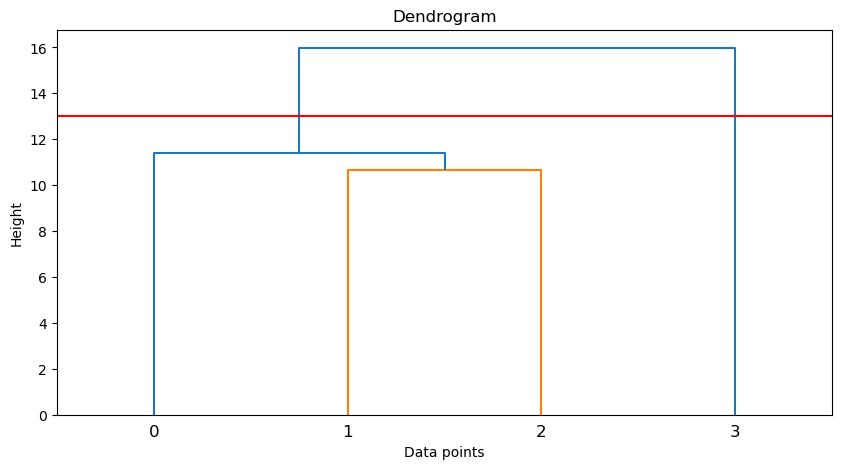

In [201]:
filtration = get_slice(filtration1, filtration2, 0.78, 0)
#filtration = get_path(filtration1, filtration2)
linkage_matrix = get_linkage_matrix(filtration)
threshold = 13
plot_merge_tree(linkage_matrix, threshold)

In [202]:
linkage_matrix

array([[ 1.        ,  2.        , 10.68      ,  2.        ],
       [ 0.        ,  4.        , 11.41025641,  3.        ],
       [ 5.        ,  3.        , 15.97435897,  4.        ]])

In [203]:
# should specify distance from dendrogram (height by y-axis)
clustering = fcluster(linkage_matrix, threshold, criterion='distance')
clustering

array([1, 1, 1, 2], dtype=int32)

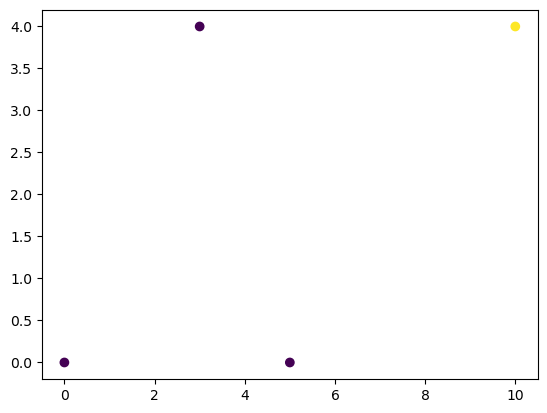

In [204]:
plt.scatter(x, y, c=clustering, cmap='viridis');

# Density-based filtration

In [205]:
# Euclidean distance filtration
rips = gd.RipsComplex(points=data)
simplex_tree = rips.create_simplex_tree(max_dimension=1)
filtration1 = transform_filtration(list(simplex_tree.get_filtration()))

Both normalized and not normalized densities have parameters to optimize. Non-normalized density filtration provides greater differences in filtration values, thus, dendrogram may be visualized in a better way.

In [206]:
kernel = 'exponential' # kernel {‘gaussian’, ‘tophat’, ‘epanechnikov’, ‘exponential’, ‘linear’, ‘cosine’}
bandwidth = 0.5
filtration2 = get_filtration_from_density(data, kernel, bandwidth)
# radius = 10
# filtration2 = get_not_normalized_filtration_from_density(data, radius)

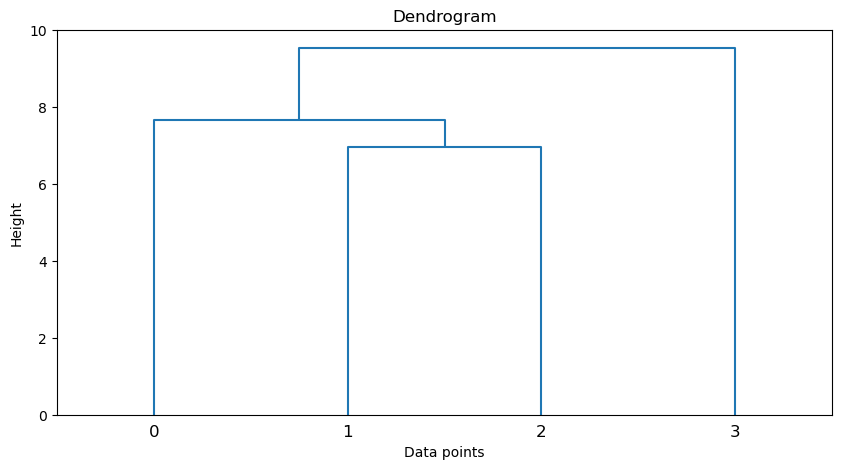

In [207]:
filtration = get_slice(filtration1, filtration2, 1/3, 1)
linkage_matrix = get_linkage_matrix(filtration)
threshold = 90
plot_merge_tree(linkage_matrix, threshold)

# Curvature filtration

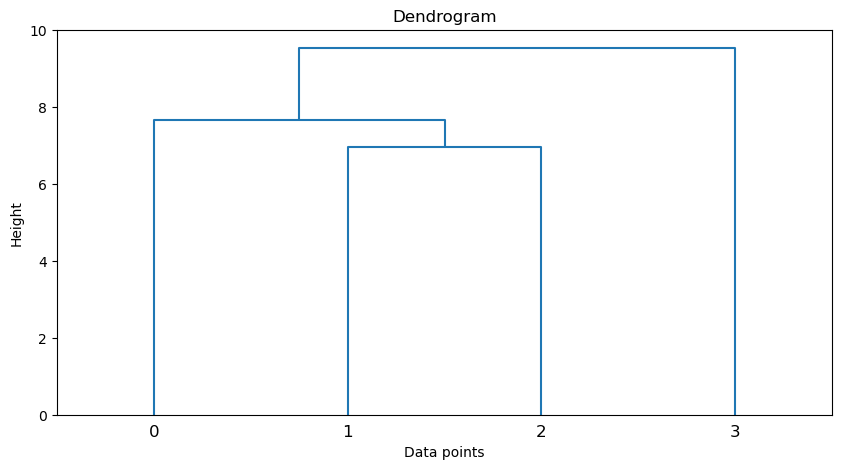

In [208]:
rips = gd.RipsComplex(points=data)
simplex_tree = rips.create_simplex_tree(max_dimension=1)
filtration1 = transform_filtration(list(simplex_tree.get_filtration()))
filtration2 = get_filtration_from_curvature(data)
filtration = get_slice(filtration1, filtration2, 1/3, 1)
linkage_matrix = get_linkage_matrix(filtration)
threshold = 90
plot_merge_tree(linkage_matrix, threshold)

# Degree-Rips

There is no default implementation of Degree-Rips. Also, filtration1 and filtration2 will depend on each other. Thus, special care is needed. \
Taking into account that it is mentioned in many articles, it may be interesting to investigate clustering using degree-rips. However, for the following approach standard degree-Rips provides correct results only if using path slicing.

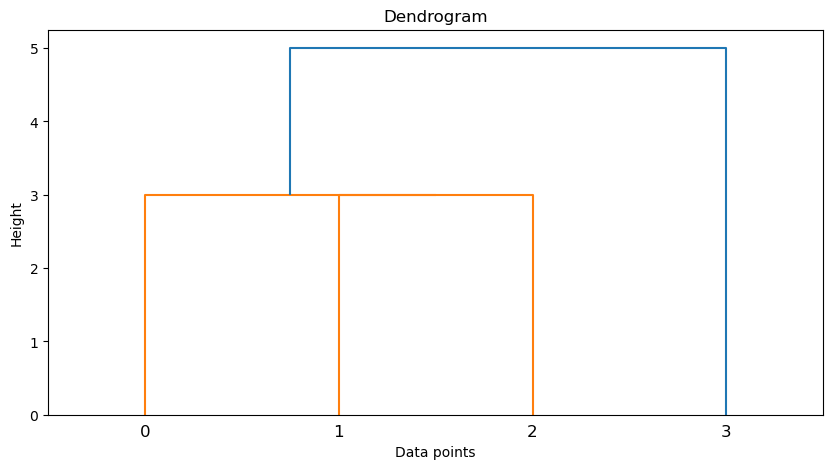

In [209]:
# Clustering based on degree-rips complex
sublevel_set = sublevelSetFunc(data, unique_dist)
filtration = get_path_from_sublevel(sublevel_set) # unsorted filtration (complex + filtration value)
linkage_matrix = get_linkage_matrix(transform_filtration(filtration))
threshold = 90
plot_merge_tree(linkage_matrix, threshold)

In [210]:
clustering = fcluster(linkage_matrix, threshold, criterion='distance')
clustering

array([1, 1, 1, 1], dtype=int32)

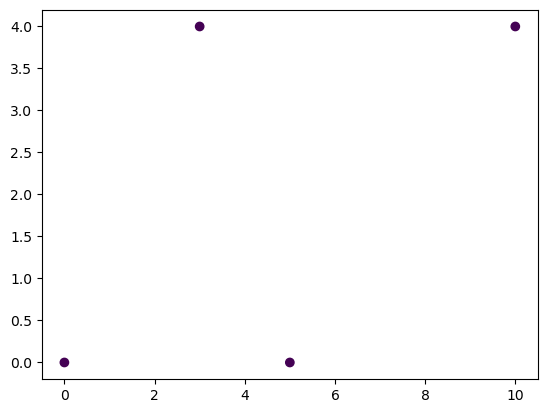

In [211]:
plt.scatter(x, y, c=clustering, cmap='viridis');

# Test section

# Time comparison

In [212]:
x = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # number of points
y2 = [0.004972219467163086, 0.0303952693939209, 0.09190082550048828, 0.21256613731384277, 0.46261119842529297, 0.9464402198791504, 1.7833478450775146, 3.0434279441833496, 4.897476673126221, 7.427850008010864] # slice
y3 = [0.001306772232055664, 0.00900888442993164, 0.02744293212890625, 0.05159711837768555, 0.06503677368164062, 0.1678938865661621, 0.44167613983154297, 0.6078720092773438, 1.0068678855895996, 1.7600939273834229] # path

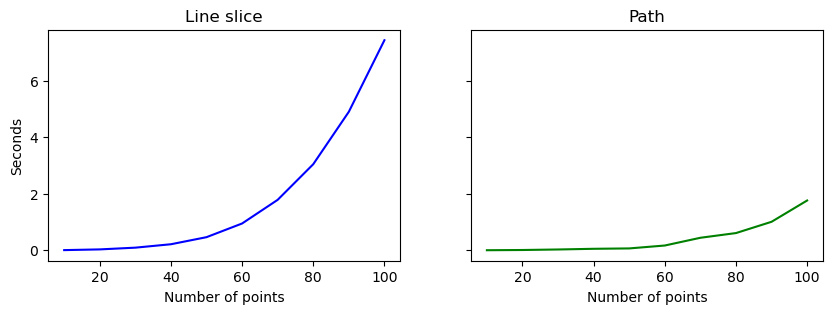

In [214]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 3))
ax1.plot(x, y2, color='blue')
ax1.set_title('Line slice')
ax1.set_xlabel('Number of points')
ax1.set_ylabel('Seconds')
ax2.plot(x, y3, color='green')
ax2.set_title('Path')
ax2.set_xlabel('Number of points')
plt.show()

# HDBSCAN data

In [3053]:
data = np.load('X_hdbscan.npy')

In [3054]:
np.random.seed(0)
random_sample = random.sample(data.tolist()[400:1500], 150)
data = np.array(random_sample)

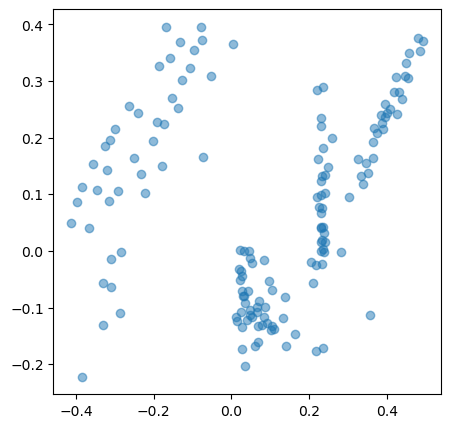

In [3055]:
plt.figure(figsize=(5,5))
plt.scatter(data[:,0], data[:,1], alpha=0.5)
plt.show()
data = data.tolist()

In [3056]:
# Configuration that leads to the result in the report is provided, however, due to random seed reproducibility
# for this concrete example is not guaranteed
K = len(data)

rips = gd.RipsComplex(points=data)
simplex_tree = rips.create_simplex_tree(max_dimension=1)
filtration2 = list(simplex_tree.get_filtration())

kernel = 'gaussian' # kernel {‘gaussian’, ‘tophat’, ‘epanechnikov’, ‘exponential’, ‘linear’, ‘cosine’}
bandwidth = 0.5
filtration1 = get_filtration_from_density(data, kernel, bandwidth)

In [3057]:
filtration = get_slice(filtration1, filtration2, 0.05, 0)
#filtration = get_path(filtration1, filtration2)
linkage_matrix = get_linkage_matrix(filtration)

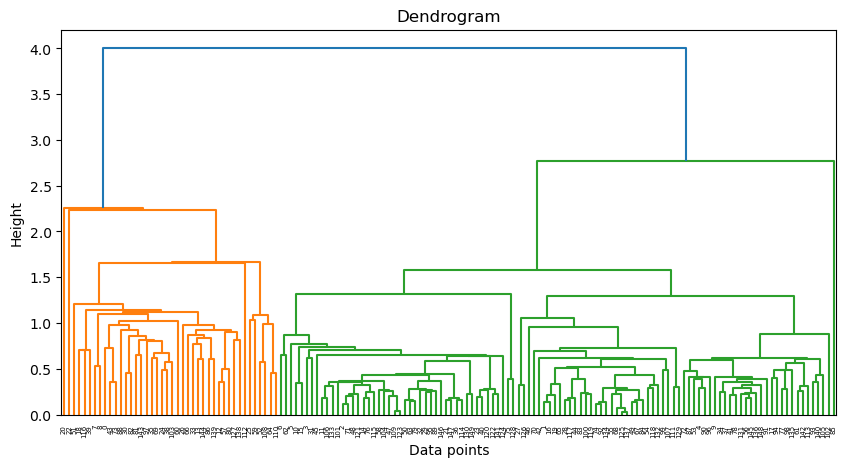

In [3058]:
threshold = 200
plot_merge_tree(linkage_matrix, threshold)

/var/folders/6r/0q3cjrvs5s7f1c9t655cz8fw0000gn/T/ipykernel_7516/2498863928.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stat = pd.concat([stat, pd.DataFrame([row])], ignore_index=True)


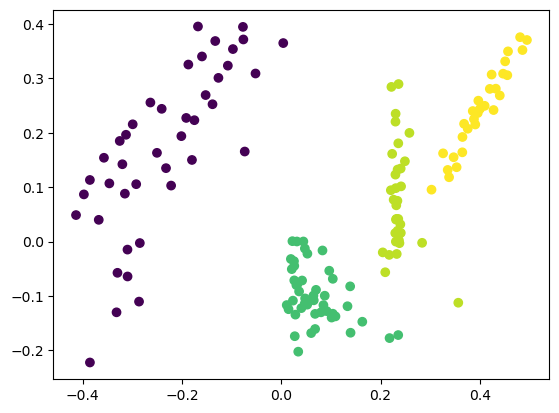

In [3090]:
from sklearn import metrics
threshold = 1.1
initial_clusters = fcluster(linkage_matrix, threshold, criterion='distance')
final_clusters = merge_clusters(data, initial_clusters, linkage_matrix, 17, squareform(pdist(data)))
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=final_clusters);
print(silhouette_score(data, final_clusters), calinski_harabasz_score(data, final_clusters))
stat1 = stat_filling(data, final_clusters, 'TDAalgo', stat1, 4)

0.35002367891550257 57.80802145017927


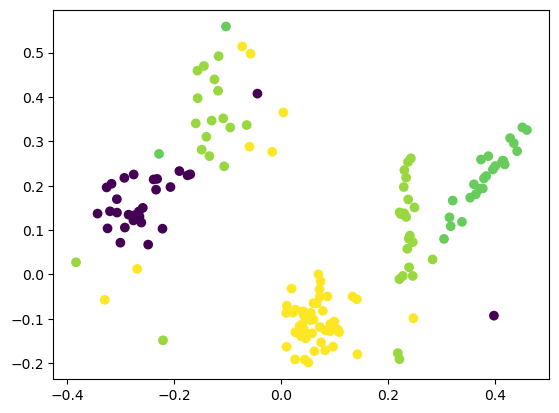

In [3001]:
# Another configurtion that shows good result for some generations
threshold = 1
initial_clusters = fcluster(linkage_matrix, threshold, criterion='distance')
final_clusters = merge_small_clusters(squareform(pdist(data)), initial_clusters, linkage_matrix, 13, distance_matrix)
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=final_clusters);
print(silhouette_score(data, final_clusters), calinski_harabasz_score(data, final_clusters))

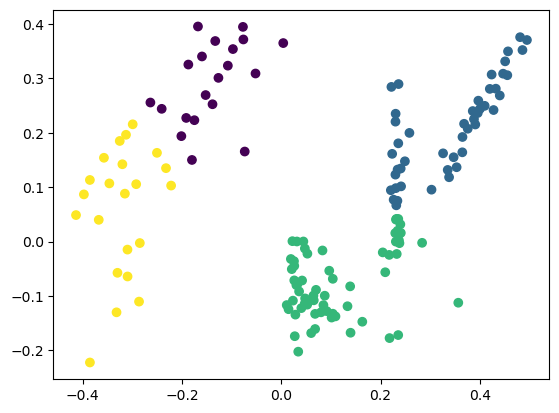

In [3100]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(data)
calinski_harabasz_score(data, kmeans.labels_)
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=kmeans.labels_, cmap='viridis');
stat1 = stat_filling(data, kmeans.labels_, 'kmeans', stat1, 4)
print(silhouette_score(data, kmeans.labels_), calinski_harabasz_score(data, kmeans.labels_))

0.4962637383636633 122.2424785861812


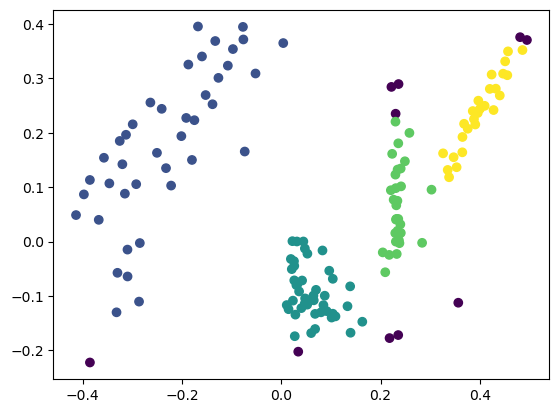

In [3102]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=6)
clusterer.fit(data)
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=clusterer.labels_, cmap='viridis');
print(silhouette_score(data, clusterer.labels_), calinski_harabasz_score(data, clusterer.labels_))
stat1 = stat_filling(data, clusterer.labels_, 'HDBSCAN', stat1, 4)

There are 5 initial clusters


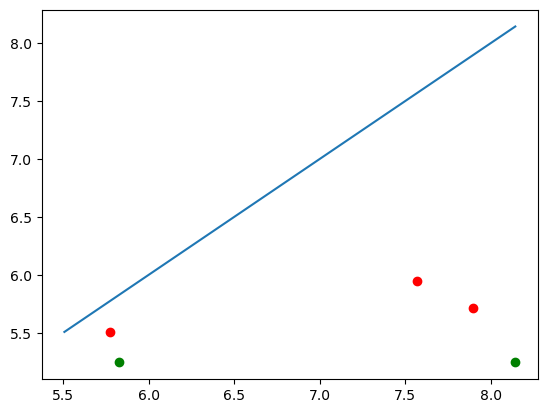

0.5419131713856711 231.935053533406


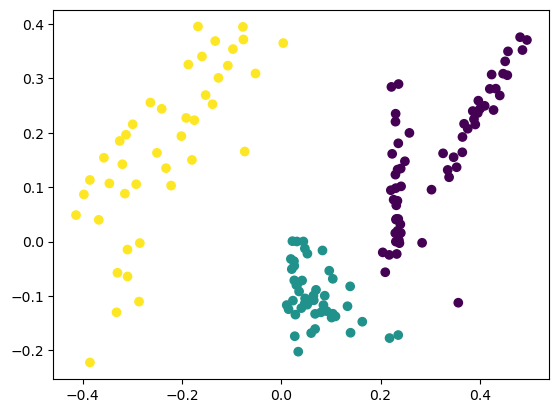

In [3105]:
clusterer = Tomato()
clusterer.fit(data)
print("There are " + str(clusterer.n_clusters_) + " initial clusters")
clusterer.plot_diagram()

clusterer.n_clusters_= 3
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=clusterer.labels_, cmap='viridis');
print(silhouette_score(data, clusterer.labels_), calinski_harabasz_score(data, clusterer.labels_))
stat1 = stat_filling(data, clusterer.labels_, 'ToMATo', stat1, 3)

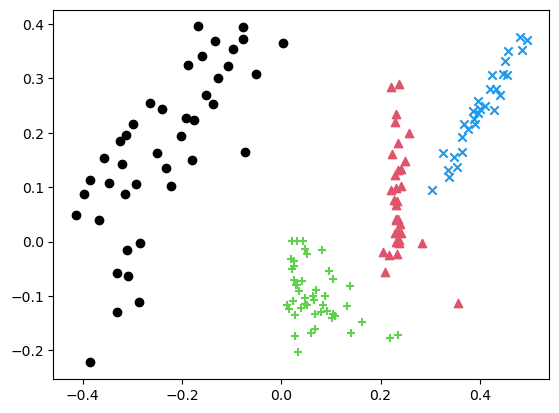

In [3107]:
clusterer = genieclust.Genie(n_clusters=4, gini_threshold=0.2)
labels = clusterer.fit_predict(data)
genieclust.plots.plot_scatter(data, labels=labels)
stat1 = stat_filling(data, clusterer.labels_, 'Genie', stat1, 4)
print(silhouette_score(data, clusterer.labels_), calinski_harabasz_score(data, clusterer.labels_))

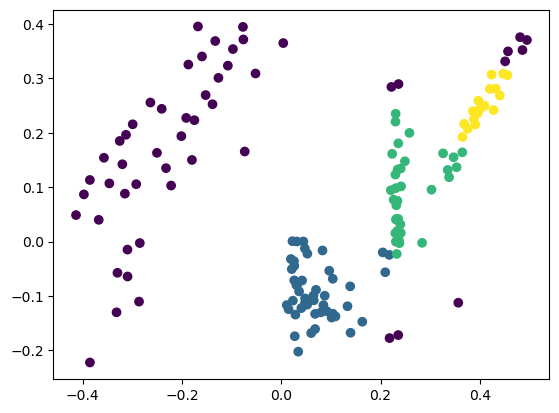

In [3129]:
dbscan_model = DBSCAN(eps=0.1, min_samples=20)
dbscan_model.fit(data)
dbscan_res = dbscan_model.fit_predict(data)
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=dbscan_res, cmap='viridis');
print(silhouette_score(data, dbscan_res), calinski_harabasz_score(data, dbscan_res))
stat1 = stat_filling(data, dbscan_res, 'DBSCAN', stat1, 4)

In [3130]:
stat1

,algo,silhouette,calinski_harabasz,clust_num,davies_bouldin
0,TDAalgo,0.524547,228.436651,4,0.623651
1,kmeans,0.552089,265.839109,4,0.632738
2,HDBSCAN,0.496264,122.242479,4,7.175518
3,ToMATo,0.541913,231.935054,3,0.558840
4,Genie,0.524547,228.436651,4,0.623651
5,DBSCAN,0.408988,64.623057,4,0.865419


# Intersecting Gaussians

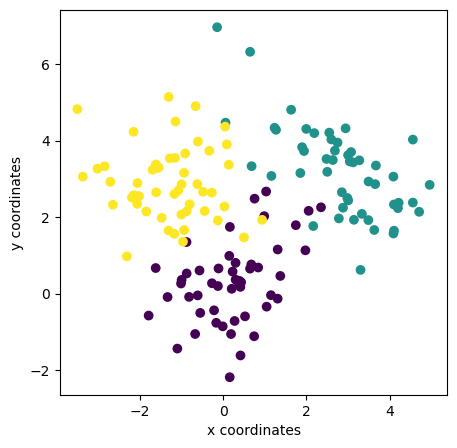

In [216]:
mean1 = [0, 0]
cov1 = [[1, 0.5], [0.5, 1]]
mean2 = [3, 3]
cov2 = [[1, -0.5], [-0.5, 1]] 
mean3 = [-1, 3]
cov3 = [[1, 0], [0, 1]]  
n_points = 50

np.random.seed(2)
data1 = np.random.multivariate_normal(mean1, cov1, n_points)
data2 = np.random.multivariate_normal(mean2, cov2, n_points)
data3 = np.random.multivariate_normal(mean3, cov3, n_points)
labels1 = np.full(n_points, 0)
labels2 = np.full(n_points, 1)
labels3 = np.full(n_points, 2)

data = np.vstack((data1, data2, data3))
labels = np.concatenate((labels1, labels2, labels3))

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
plt.xlabel('x coordinates')
plt.ylabel('y coordinates')
plt.show()

In [217]:
K = len(data)
filtration1 = get_filtration_from_scipy_dist(data, 'euclidean')
kernel = 'gaussian' # kernel {‘gaussian’, ‘tophat’, ‘epanechnikov’, ‘exponential’, ‘linear’, ‘cosine’}
bandwidth = 0.5
filtration2 = get_filtration_from_scipy_dist(data, 'jaccard')
# filtration2 = get_not_normalized_filtration_from_density(data, r=0.6)
# filtration2 = get_filtration_from_density(data, kernel, bandwidth)
# filtration2 = get_filtration_from_curvature(data, kernel, bandwidth)
filtration = get_slice(filtration1, filtration2, 1 , 1) 
#filtration = get_path(filtration1, filtration2)
linkage_matrix = get_linkage_matrix(filtration)

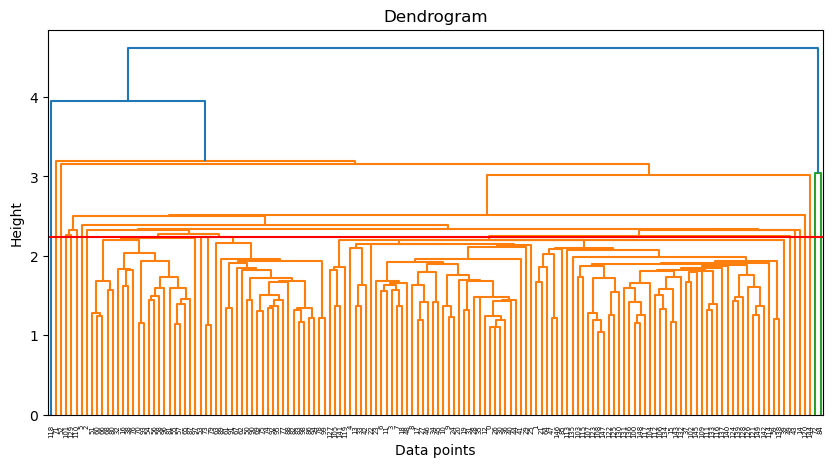

In [218]:
threshold = 2.23
plot_merge_tree(linkage_matrix, threshold)

0.7748564521003324


/var/folders/6r/0q3cjrvs5s7f1c9t655cz8fw0000gn/T/ipykernel_86318/1259090196.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stat = pd.concat([stat, pd.DataFrame([row])], ignore_index=True)


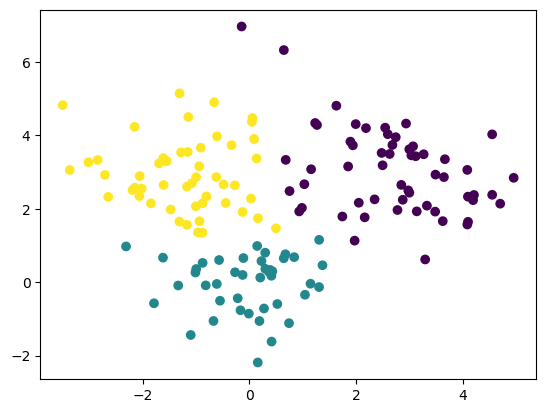

In [225]:
num_clusters = 40
initial_clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')
#final_clusters = initial_clusters
final_clusters = merge_clusters(data, initial_clusters, linkage_matrix, 10, squareform(pdist(data)))
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=final_clusters);
print(adjusted_rand_score(labels, final_clusters))
stat2 = stat_filling2(data, final_clusters, 'TDAalgo', stat2, 3, labels)

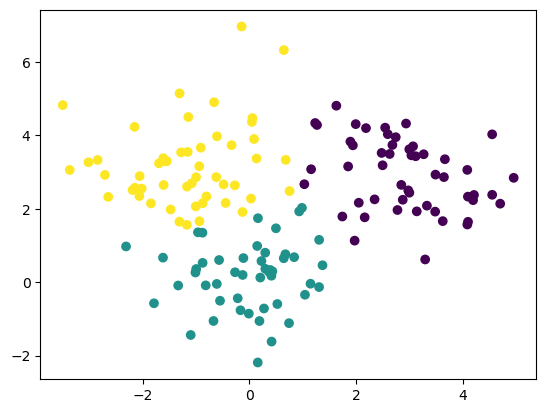

In [226]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(data)
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=kmeans.labels_, cmap='viridis');
adjusted_rand_score(labels, kmeans.labels_)
stat2 = stat_filling2(data, kmeans.labels_, 'kmeans', stat2, 3, labels)

0.4279994621160528


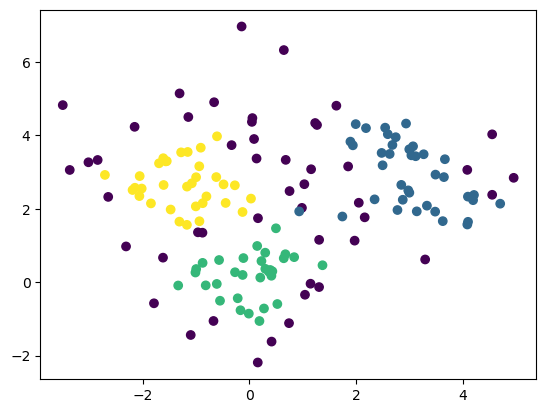

In [227]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=6)
clusterer.fit(data)
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=clusterer.labels_, cmap='viridis');
print(adjusted_rand_score(labels, clusterer.labels_))
stat2 = stat_filling2(data, clusterer.labels_, 'HDBSCAN', stat2, 3, labels)

There are 7 initial clusters


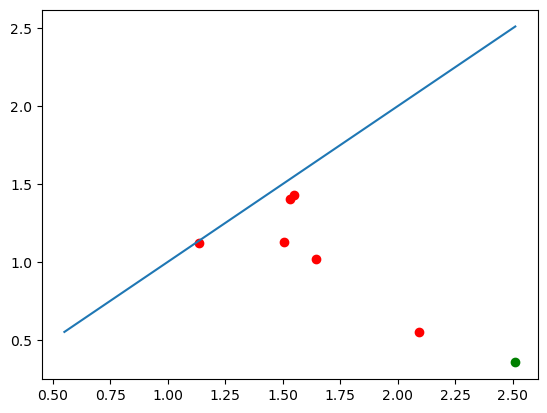

0.7714993511855609


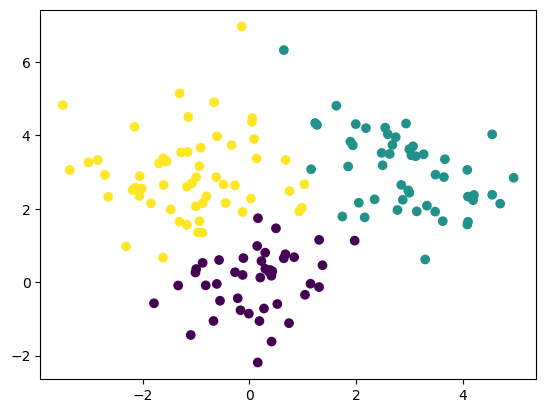

In [228]:
clusterer = Tomato()
clusterer.fit(data)
print("There are " + str(clusterer.n_clusters_) + " initial clusters")
clusterer.plot_diagram()

clusterer.n_clusters_= 3
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=clusterer.labels_, cmap='viridis');
print(adjusted_rand_score(labels, clusterer.labels_))
stat2 = stat_filling2(data, clusterer.labels_, 'ToMATo', stat2, 3, labels)

1.0


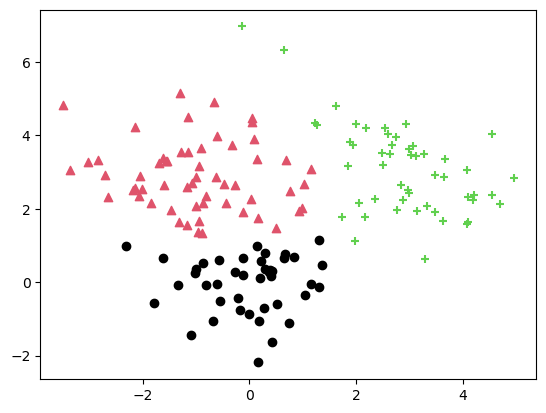

In [229]:
clusterer = genieclust.Genie(n_clusters=3, gini_threshold=0.2)
labels = clusterer.fit_predict(data)
genieclust.plots.plot_scatter(data, labels=labels)
print(adjusted_rand_score(labels, clusterer.labels_))
stat2 = stat_filling2(data, clusterer.labels_, 'Genie', stat2, 3, labels)

0.7444498748117641


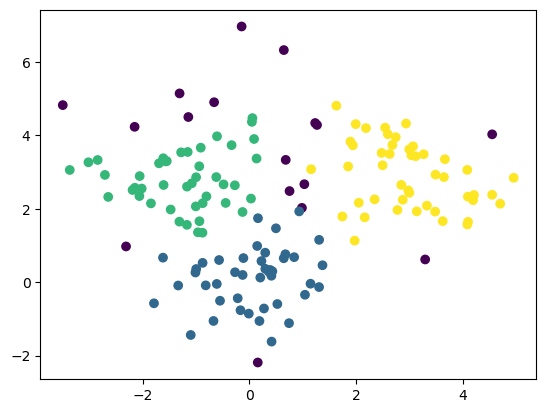

In [230]:
dbscan_model = DBSCAN(eps=0.7, min_samples=5)
dbscan_model.fit(data)
dbscan_res = dbscan_model.fit_predict(data)
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=dbscan_res, cmap='viridis');
print(adjusted_rand_score(labels, dbscan_res))
stat2 = stat_filling2(data, dbscan_res, 'DBSCAN', stat2, 3, labels)

In [231]:
stat2

,algo,ARI,silhouette,calinski_harabasz,clust_num
0,TDAalgo,0.774856,0.479026,174.223959,3.0
1,kmeans,0.741179,0.488754,187.852852,3.0
2,HDBSCAN,0.427999,0.262480,47.728445,3.0
3,ToMATo,0.771499,0.480045,179.337885,3.0
4,Genie,1.000000,0.474298,171.351336,3.0
5,DBSCAN,0.744450,0.423243,100.785517,3.0
